In [23]:
# Appeding the path to the scaman package
import sys
sys.path.append('/Users/berke/Codes/scaman-2024/scaman') 
# flann path
sys.path.append('/Users/berke/Codes/python/flann/src/python')
import numpy as np

In [24]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import scipy.io as sio

# Load data
X_dict = sio.loadmat('/Users/berke/Codes/scaman-2024/tests/data/salinas/org/salinas.mat')
y_dict = sio.loadmat('/Users/berke/Codes/scaman-2024/tests/data/salinas/org/salinas_gt.mat')

X = X_dict['salinas'].reshape(-1, 224)
y = y_dict['salinas_gt'].reshape(-1,1)

# Stratified sampling: 10% of the data
X, _, y, _ = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

In [25]:
# Step 2: Center data matrix
import numpy as np
means = np.mean(X, axis=0)
X_centered = X - means
# Step 3: Verify that covariance matrix is centered
assert np.allclose(np.mean(X_centered, axis=0), np.zeros_like(means))

In [26]:
# Step 4: Compute covariance matrix
cov = np.cov(X, rowvar=False)
eigs = np.linalg.eig(cov)[0]
eigs_sorted = np.flip(np.sort(eigs))
variances = np.cumsum(eigs_sorted)/np.sum(eigs_sorted)
tv = 0.8


In [27]:
from serial.pca import PCA
import time
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [29]:
estDim=8

In [30]:
## Created test with estimated dimension and PCA
start_time_est_pca = time.time()
#X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=estDim,solver='slepc')
embedding_pca = pca.fit_transform(X)
end_time_est_pca = time.time()
#embedding shape
print(embedding_pca.shape)
#embedding type
print(type(embedding_pca))
print(f"Time taken: {end_time_est_pca - start_time_est_pca} seconds")
# convert complex matrix to real matrix
#embedding_pca = np.real(embedding_pca)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 8
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 10

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.80302e-16
 13766318.085671       1.52984e-15
 644000.103023       7.58047e-15
 308883.446167       3.50772e-14
 100103.043499       3.66795e-14
 31452.082446       2.53452e-13
 14063.717532       4.43562e-13
  8695.569320       4.94443e-13
  5283.811748       4.70992e-12
  3461.193189       1.13034e-09

(11110, 8)
<class 'numpy.ndarray'>
Time taken: 0.03933906555175781 seconds


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.3, random_state=42)

# Fit the KNN model on the training data
start_time_est_knn = time.time()
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
end_time_est_knn = time.time()

# Use the trained model to predict the labels for the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of PCA applied data with estDim: {accuracy}")
print(f"Time taken: {end_time_est_knn - start_time_est_knn} seconds")

Accuracy of PCA applied data with estDim: 0.8646864686468647
Time taken: 0.0021948814392089844 seconds


/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [32]:
time_taken_intrinsic = 0.622 + (end_time_est_pca - start_time_est_pca) + (end_time_est_knn - start_time_est_knn)
print(f"Total time taken: {time_taken_intrinsic} seconds")

Total time taken: 0.6635339469909668 seconds


In [33]:
# Split the data into training and testing sets for original data
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=42)
start_time_org_knn = time.time()
# Fit the KNN model on the training data for original data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_org, y_train_org)
end_time_org_knn = time.time()

# Use the trained model to predict the labels for the testing data for original data
y_pred_org = knn.predict(X_test_org)

# Calculate the accuracy of the model for original data
accuracy_org = accuracy_score(y_test_org, y_pred_org)
print(f"Accuracy of original dataset: {accuracy_org}")
print(f"Time taken: {end_time_org_knn - start_time_org_knn} seconds")

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of original dataset: 0.8645364536453646
Time taken: 0.0015511512756347656 seconds


In [34]:
import time

# Initialize an empty list to store the accuracies and times
accuracies = []
times = []

# Define the range of dimensions
dimensions = range(2, 50, 2)

# Loop through each dimension
for dim in dimensions:
    start_time = time.time()
    
    # Perform PCA with the current dimension
    pca = PCA(n_components=dim,solver='slepc')
    embedding_pca = pca.fit_transform(X)
    embedding_pca = np.real(embedding_pca)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embedding_pca, y, test_size=0.2, random_state=42)
    
    # Fit the KNN model on the training data
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, y_train)
    
    # Use the trained model to predict the labels for the testing data
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Print the accuracies and times for each dimension
for dim, accuracy, time_taken in zip(dimensions, accuracies, times):
    print(f"Dimension: {dim}, Accuracy: {accuracy}, Time taken: {time_taken} seconds")

print(accuracies)
print(times)

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 2
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 8

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044        8.5239e-16
 13766318.085671       1.48862e-15
 644000.103023       9.04291e-15
 308883.446167       2.73776e-14
 100103.043499       3.60074e-14
 31452.082446       1.28564e-13
 14063.717532       3.04757e-10
  8695.569320       1.11074e-07

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 4
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 9

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
---------------

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarnin

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 10
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 11

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       7.68293e-16
 13766318.085671       1.51173e-15
 644000.103023       8.24237e-15
 308883.446167       2.62345e-14
 100103.043499       3.44198e-14
 31452.082446       1.38009e-13
 14063.717532       2.67529e-13
  8695.569320       3.95109e-13
  5283.811748       5.69672e-13
  3461.193189       4.42443e-12
  2351.889978       6.99986e-08

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 12
Stopping condition: tol=1e-06, maxit=100

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarnin

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 18
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 20

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.89319e-16
 13766318.085671        1.5563e-15
 644000.103023       8.04319e-15
 308883.446167       3.54988e-14
 100103.043499       3.10979e-14
 31452.082446       2.16625e-13
 14063.717532       2.66704e-13
  8695.569320       3.83641e-13
  5283.811748       4.30112e-13
  3461.193189       1.49758e-12
  2351.889978       7.39066e-13
  1923.653387       1.67065e-12
  1619.838945       1.97701e-12
  1507.732272       1.32535e-12
  1067.745624       2.55623e-12
  1053.449253       3.43552e-12
   917.957441        4.0274e-12
   723.565112       7.36064e-10
   604.935986       1.88326e-10
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 22
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 23

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.64866e-16
 13766318.085671       1.45474e-15
 644000.103023       8.82078e-15
 308883.446167       3.53788e-14
 100103.043499        4.0037e-14
 31452.082446       1.69533e-13
 14063.717532       4.23774e-13
  8695.569320       4.76814e-13
  5283.811748       3.61852e-13
  3461.193189        9.8828e-13
  2351.889978       4.76709e-13
  1923.653387       1.15089e-12
  1619.838945       9.26645e-13
  1507.732272       1.70494e-12
  1067.745624       1.83339e-12
  1053.449253        3.4791e-12
   917.957441       3.79126e-12
   723.565112       3.64184e-12
   604.935986       4.70329e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 26
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 26

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.94838e-16
 13766318.085671       1.60912e-15
 644000.103023       9.02509e-15
 308883.446167       2.67534e-14
 100103.043499       3.52303e-14
 31452.082446       1.39287e-13
 14063.717532       3.20186e-13
  8695.569320       4.37626e-13
  5283.811748       4.49663e-13
  3461.193189       1.10171e-12
  2351.889978       1.05516e-12
  1923.653387        1.0191e-12
  1619.838945       1.43646e-12
  1507.732272       1.35145e-12
  1067.745624       3.11943e-12
  1053.449253       2.11022e-12
   917.957441       5.02815e-12
   723.565112       2.31246e-12
   604.935986       5.56706e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 32
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 32

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.75795e-16
 13766318.085671        1.4872e-15
 644000.103023       9.17188e-15
 308883.446167       2.82335e-14
 100103.043499       3.81085e-14
 31452.082446       2.46115e-13
 14063.717532       2.61308e-13
  8695.569320       3.88742e-13
  5283.811748       5.00244e-13
  3461.193189       1.05829e-12
  2351.889978       7.41632e-13
  1923.653387        1.0291e-12
  1619.838945       2.02263e-12
  1507.732272       1.11809e-12
  1067.745624       2.68662e-12
  1053.449253       2.15367e-12
   917.957441       4.30532e-12
   723.565112       2.95718e-12
   604.935986       5.88467e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 36
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 36

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       7.04193e-16
 13766318.085671        1.6311e-15
 644000.103023       7.51805e-15
 308883.446167       2.33843e-14
 100103.043499       3.44973e-14
 31452.082446       1.75518e-13
 14063.717532       3.11448e-13
  8695.569320       4.43716e-13
  5283.811748       4.11458e-13
  3461.193189       9.01767e-13
  2351.889978       4.87542e-13
  1923.653387       1.17157e-12
  1619.838945       1.51595e-12
  1507.732272       1.11625e-12
  1067.745624        1.9501e-12
  1053.449253       1.82636e-12
   917.957441       2.57739e-12
   723.565112       2.64518e-12
   604.935986       3.28237e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 40
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 46

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       7.04824e-16
 13766318.085671       1.56958e-15
 644000.103023       8.16665e-15
 308883.446167       4.66167e-14
 100103.043499       3.25304e-14
 31452.082446        1.8361e-13
 14063.717532       4.91024e-13
  8695.569320       3.30538e-13
  5283.811748       5.91088e-13
  3461.193189       1.58683e-12
  2351.889978       9.17421e-13
  1923.653387       1.97207e-12
  1619.838945       1.19913e-12
  1507.732272       1.67534e-12
  1067.745624       2.55212e-12
  1053.449253       2.80761e-12
   917.957441       2.77383e-12
   723.565112       3.30877e-12
   604.935986        5.1064e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 44
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 55

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       6.74909e-16
 13766318.085671       1.51546e-15
 644000.103023       7.46651e-15
 308883.446167       2.60132e-14
 100103.043499       3.66855e-14
 31452.082446       2.40838e-13
 14063.717532       3.23707e-13
  8695.569320       4.53163e-13
  5283.811748       5.29151e-13
  3461.193189       9.51484e-13
  2351.889978       7.34099e-13
  1923.653387       8.77077e-13
  1619.838945        2.0314e-12
  1507.732272       2.02711e-12
  1067.745624       4.82092e-12
  1053.449253       2.34047e-12
   917.957441       5.62251e-12
   723.565112       2.35401e-12
   604.935986       7.84578e-12
   

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 46
Stopping condition: tol=1e-06, maxit=100
Number of converged eigenpairs 58

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
 42492020.869044       8.53812e-16
 13766318.085671        1.4974e-15
 644000.103023       8.34705e-15
 308883.446167       2.85671e-14
 100103.043499       4.14106e-14
 31452.082446       2.04658e-13
 14063.717532       3.72121e-13
  8695.569320       5.41557e-13
  5283.811748       3.08372e-13
  3461.193189       7.58289e-13
  2351.889978       9.53468e-13
  1923.653387       9.86331e-13
  1619.838945       1.34736e-12
  1507.732272       1.16467e-12
  1067.745624        2.6655e-12
  1053.449253       2.53383e-12
   917.957441       2.49183e-12
   723.565112       3.03334e-12
   604.935986        7.6011e-12
   473.669412       1.4

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [35]:
time_taken_loop = np.sum(times)
print(f"Total time taken: {np.sum(times)} seconds")

Total time taken: 2.7712152004241943 seconds


In [36]:
# Create lists of dimensions and accuracies
dimensions = list(range(2, 50, 2))

In [37]:

dimensions.append(estDim)
accuracies.append(accuracy)

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_34605/529647466.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Accuracies')


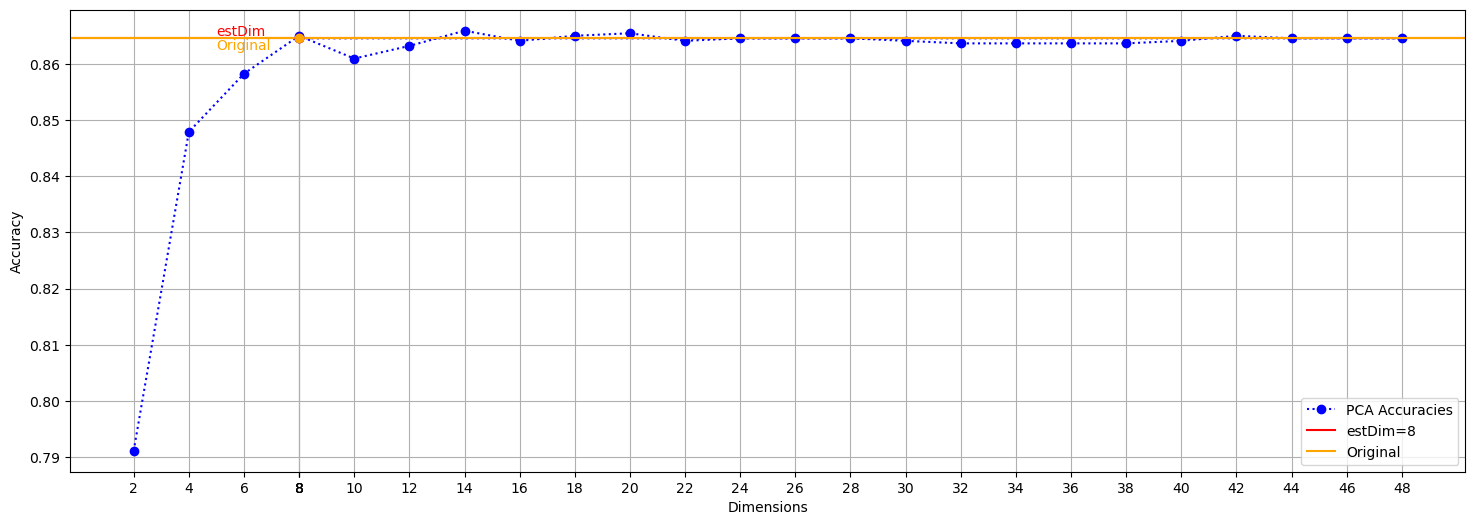

In [38]:
import matplotlib.pyplot as plt


#accuracies.append(accuracy)

# Set the size of the plot
plt.figure(figsize=(18, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Accuracies')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original')
plt.text(5, accuracy_org, 'Original', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
#plt.title('Salinas - Scaman PCA and kNN Accuracies with Dimension Estimator')
plt.legend()

plt.show()

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_34605/2397818329.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')
/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_34605/2397818329.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


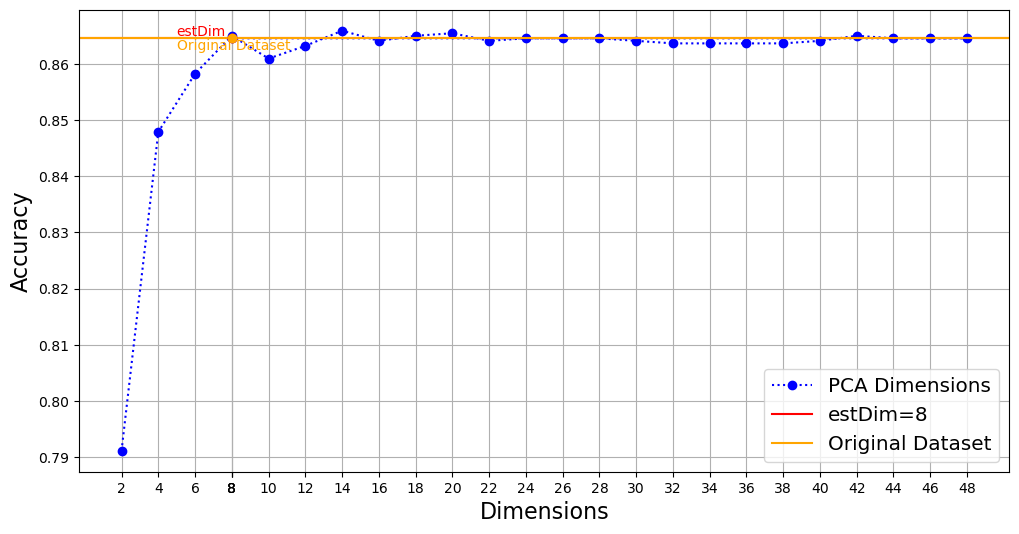

In [40]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(12, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='PCA Dimensions')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original Dataset')
plt.text(5, accuracy_org, 'Original Dataset', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.title('Indian Pines - PCA and kNN Accuracies with Dimension Estimator', fontsize=16)

# Create a legend with larger font size
legend = plt.legend(fontsize='x-large')

# Increase the size of the legend markers
for handle in legend.legendHandles:
    handle._sizes = [85]

plt.show()